# SafeNSound: Initial Log Scaled Mel-Spectrogram Development

## 1. Importing Libraries

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display as ld
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import sounddevice as sd
from sklearn.model_selection import train_test_split

## 2. Datasets

In [39]:
PATH = "datasets/"
EMERGENCY_PATH = os.path.join(PATH, "emergency/")
NORMAL_PATH = os.path.join(PATH, "non-emergency/")

def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr

#get audio real-time
## def record_audio(duration=5, sample_rate=16000):

## 3. Creating Mel Spectrogram & converting to Log Scale

In [40]:
def log_scaled_melspectrogram(audio, sample_rate, n_fft=1024, hop_length=512, n_mels=128, max_len=160):
    S = lb.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    if S.shape[1] < max_len:
        S = np.pad(S, ((0,0),(0, max_len - S.shape[1])), mode='constant')
    else:
        S = S[:, :max_len]

    S_dB = lb.power_to_db(S, ref=np.max)
    
    S_dB = S_dB[..., np.newaxis]
    
    return S_dB

## 4. Display Log-scaled Mel Spectrogram

In [41]:
X = []
y = []
labels = {"emergency": 1, "non-emergency": 0}

emergency_labels = {"crying sound", "door noise", "glassbreak sounds", "gunshots", "screaming sound"}
non_emergency_labels = {"clap", "door sound", "fireworks", "object noise", "toilet noise"}

emergency_count = 0;
non_emergency_count = 0;

for label, idx in labels.items():
    main_path = EMERGENCY_PATH if label == "emergency" else NORMAL_PATH
    subfolders =  emergency_labels if label == "emergency" else non_emergency_labels
            
    for subfolder in subfolders:
        folder = os.path.join(main_path, subfolder)

        if not os.path.exists(folder):
            print(f"Warning: Directory {folder} does not exist. Skipping...")
            continue

        for file in os.listdir(folder):
            if file.endswith(".wav"):
                try:
                    wav, sr = load_audio_files(folder, file)
                    lsms = log_scaled_melspectrogram(wav, sr)

                    # try:
                    #     plt.figure(figsize=(12, 5))
                    #     lb.display.specshow(lsms, x_axis='time', sr=sr)
                    #     plt.colorbar()
                    #     plt.title(file)
                    #     plt.tight_layout()
                    #     plt.show()
                    # except Exception as e:
                    #     print(f"Error displaying Melspectrogram for {file}: {e}")
                    #     continue

                    X.append(lsms)
                    y.append(idx)

                    if label == "emergency":
                        emergency_count += 1   
                    else:
                        non_emergency_count += 1

                except Exception as e:
                    print(f"Error processing {file} in {folder}: {e}")
                    continue

X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=2)

## 5. Split

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## 6. CNN

In [ ]:
def build_cnn(input_shape, num_classes=2):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [53]:
input_shape = (X.shape[1], X.shape[2], X.shape[3])

model = build_cnn(input_shape, num_classes=2)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     5,242,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,262,274 (20.07 MB)

 Trainable params: 5,262,082 (20.07 MB)

 Non-trainable params: 192 (768.00 B)

## 7. Train

In [54]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4000 - loss: 2.9844 - val_accuracy: 0.6000 - val_loss: 256.7556
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6400 - loss: 36.2441 - val_accuracy: 0.6000 - val_loss: 400.1705
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8400 - loss: 13.8684 - val_accuracy: 0.6000 - val_loss: 466.2607
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8800 - loss: 7.0755 - val_accuracy: 0.6000 - val_loss: 489.4598
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9200 - loss: 8.1122 - val_accuracy: 0.6000 - val_loss: 475.5201
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9200 - loss: 5.0776 - val_accuracy: 0.6000 - val_loss: 439.9024
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9200 - loss: 4.8169 - val_accuracy: 0.6000 - val_loss: 389.6617
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9200 - loss: 3.1097 - val_accuracy: 0.600

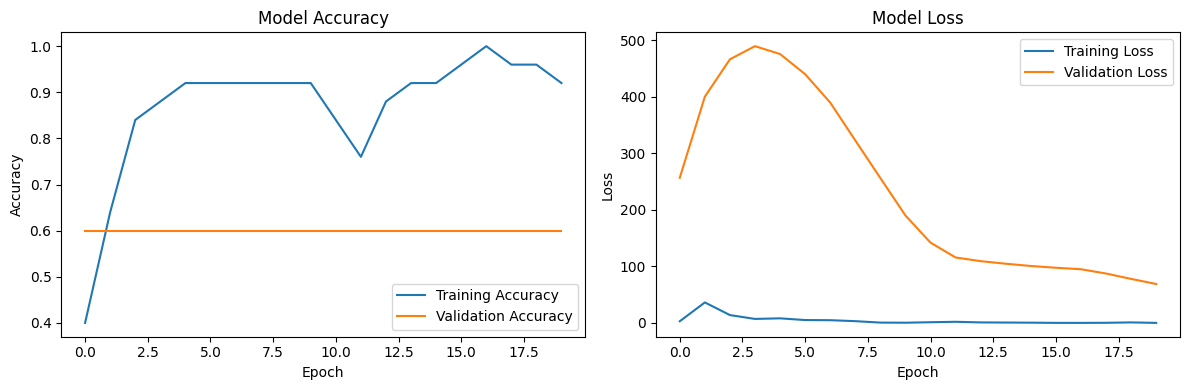

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6667 - loss: 66.3599
Test accuracy: 0.6666666865348816


In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)